# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

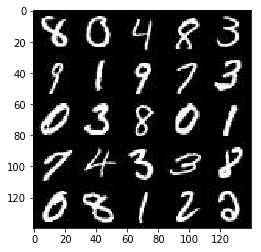

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

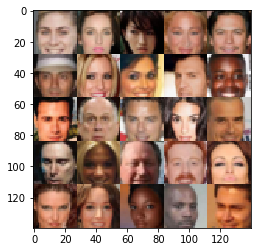

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/darren/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha=0.1

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xc
        x1 = tf.layers.conv2d(images,
                              64,
                              5,
                              strides=2,
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        d1 = tf.layers.dropout(inputs=x1, rate=0.5, training=True)
        relu1 = tf.maximum(alpha * d1, d1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1,
                              128,
                              5,
                              strides=2,
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        d2 = tf.layers.dropout(inputs=bn2, rate=0.5, training=True)
        relu2 = tf.maximum(alpha * d2, d2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2,
                              256,
                              4,
                              strides=2,
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        d3 = tf.layers.dropout(inputs=bn3, rate=0.5, training=True)
        relu3 = tf.maximum(alpha * d3, d3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat,
                                 1,
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        dropout = tf.layers.dropout(inputs=logits, rate=0.5, training=True)
        output = tf.sigmoid(dropout)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z,
                             4*4*512,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1,
                                        192,
                                        4,
                                        strides=1,
                                        padding='valid',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x192 now

        x3 = tf.layers.conv2d_transpose(x2,
                                        64,
                                        5,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x3,
                                            out_channel_dim,
                                            5,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28 x 28 x out_channel_dim

        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * (1 - smooth)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """

Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 320
    show_every = 100
    n_images = 6
    
    image_width = list(data_shape)[1]
    image_height = list(data_shape)[2]
    image_channels = list(data_shape)[3]

    input_real, input_z, _ = model_inputs(image_width,
                                        image_height,
                                        image_channels,
                                        z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # As per Project Review #1
                batch_images = batch_images*2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

            show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 2.3008
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 2.1897
Epoch 1/2... Discriminator Loss: 1.9468... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 3.0040... Generator Loss: 1.3249
Epoch 1/2... Discriminator Loss: 0.7446... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 1.5982
Epoch 1/2... Discriminator Loss: 1.5987... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 1.0103
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 1.0274
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.3940
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 1.1208
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 1.2506
Epoch 1/2... Discriminator Loss: 2.5246... Generator Loss: 0.5077
Epoch 1/2.

Epoch 1/2... Discriminator Loss: 1.5683... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 0.9209... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 0.7897... Generator Loss: 1.5802
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 1.1583
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.0396
Epoch 1/2... Discriminator Loss: 2.0722... Generator Loss: 0.6694
Epoch 1/2... Discriminator Loss: 2.3684... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 0.9829... Generator Loss: 0.9698
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 1.1444
Epoch 1/2... Discriminator Loss: 1.4699... Generator Loss: 0.6465
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.5078
Epoch 1/2.

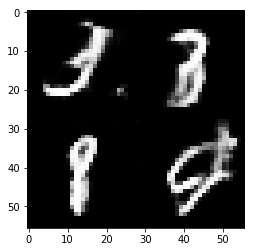

Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 1.7073... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 1.4151
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 1.0641... Generator Loss: 0.4504
Epoch 2/2... Discriminator Loss: 1.1487... Generator Loss: 0.4026
Epoch 2/2... Discriminator Loss: 1.6022... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 0.5449
Epoch 2/2... Discriminator Loss: 1.0697... Generator Loss: 1.2393
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.7155... Generator Loss: 1.0629
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.7385
Epoch 2/2.

Epoch 2/2... Discriminator Loss: 1.1419... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 1.3378
Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 2.2779... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 0.6215
Epoch 2/2... Discriminator Loss: 1.5415... Generator Loss: 0.9254
Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 2.0947... Generator Loss: 0.5060
Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 0.7148
Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.7227
Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 1.0283
Epoch 2/2... Discriminator Loss: 1.6334... Generator Loss: 0.5093
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.9227
Epoch 2/2.

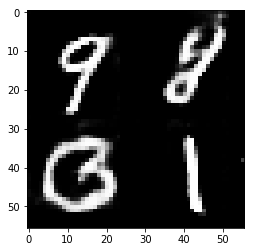

In [13]:
batch_size = 1
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 2.6568
Epoch 1/1... Discriminator Loss: 0.6775... Generator Loss: 1.9091
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.8159
Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 2.3323... Generator Loss: 1.6590
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 2.0222
Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 1.9684
Epoch 1/1... Discriminator Loss: 0.6642... Generator Loss: 2.1599
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 1.4940
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.4094
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 1.6595... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.2382
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.9047... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.6880... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.7560... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.6375
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.2119
Epoch 1/1.

Epoch 1/1... Discriminator Loss: 1.6460... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.8669... Generator Loss: 0.7804


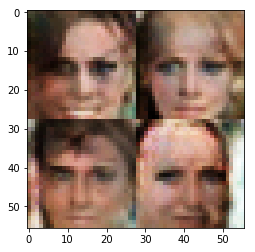

In [14]:
batch_size = 1
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.